# Import Libraries

In [1]:
!pip install plot_keras_history

In [2]:
import pandas as pd
import numpy as np
from keras import layers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D,Reshape, Dense, Dropout, Flatten, MaxPooling1D, Input, Concatenate
from keras.models import load_model
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib
import matplotlib.pyplot as plt
from plot_keras_history import plot_history
from keras import Model
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read Dataset

In [3]:
news=pd.read_table('r8-full-data.txt',header=None,names = ["Class", "Text"])
news.head()

,Class,Text
0,trade,asian exporters fear damage from u s japan rif...
1,grain,china daily says vermin eat pct grain stocks a...
2,ship,australian foreign ship ban ends but nsw ports...
3,acq,sumitomo bank aims at quick recovery from merg...
4,earn,amatil proposes two for five bonus share issue...


In [4]:
a = news.groupby("Class")
a.describe()

Text                                                               
         count unique                                                top freq
Class                                                                        
acq       2292   2285  nippon life shearson tie up seen setting trend...    2
crude      374    366  reagan says u s needs to lessen oil imports pr...    2
earn      3923   3915  bristol myers co bmy rd qtr net shr cts vs cts...    2
grain       51     51  ussr crop weather summary usda noaa gradual wa...    1
interest   271    249  canada day t bills average pct making bank rat...    3
money-fx   293    280  sumita says bank will intervene if necessary b...    3
ship       144    141  agency reports ships waiting at panama canal t...    3
trade      326    312  bank of japan calls for long term efforts on t...    2

In [5]:
y=news['Class']
X=news['Text']

<Figure size 432x288 with 0 Axes>

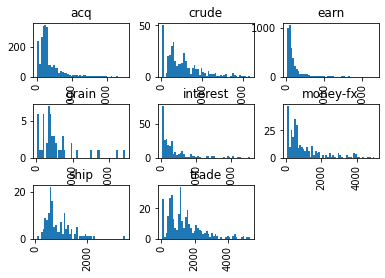

<Figure size 432x288 with 0 Axes>

In [6]:
# Check the length to determine the document length for DNN
length=news['Text'].apply(len)
news=news.assign(Length=length)

# Plot the distribution of the document length for each category
news.hist(column='Length',by='Class',bins=50)
plt.figure()

# Data Preprocessing 

In [7]:
# Split train & test
text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [8]:
# tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)
X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

In [9]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Adding 1 because of PAD
maxlen = max(len(x) for x in X_train) # longest text in train set
print('vocabubary size:',vocab_size)
print('max length text:',maxlen)

vocabubary size: 19998
max length text: 964


In [10]:
# Padding the sentences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [11]:
# embedding dimension should align with the GLOVE
embedding_dim = 100
vocab_size = len(word_index) + 1

GLOVE_6B_100D_PATH ="/content/drive/MyDrive/glove.6B.100d.txt"
encoding="utf-8"
with open(GLOVE_6B_100D_PATH, "rb") as lines:
    embeddings_index = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

# Prepare embedding matrix from pre-trained model
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Check % words with embeddings 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)   

0.848034803480348


In [12]:
pd.DataFrame(embedding_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
1,-0.038194,-0.244870,0.728120,-0.399610,0.083172,0.043953,-0.391410,0.334400,-0.57545,0.087459,0.287870,-0.06731,0.309060,-0.26384,-0.132310,-0.207570,0.33395,-0.338480,-0.31743,-0.48336,0.146400,-0.373040,0.34577,0.052041,0.449460,-0.46971,0.026280,-0.541550,-0.15518,-0.14107,-0.039722,0.28277,0.143930,0.23464,-0.31021,0.086173,0.20397,0.526240,0.171640,-0.082378,...,-0.249780,0.92136,0.034514,0.467450,1.10790,-0.193580,-0.074575,0.233530,-0.052062,-0.220440,0.057162,-0.15806,-0.307980,-0.416250,0.379720,0.150060,-0.532120,-0.205500,-1.252600,0.071624,0.70565,0.49744,-0.420630,0.261480,-1.53800,-0.302230,-0.073438,-0.28312,0.371040,-0.252170,0.016215,-0.017099,-0.38984,0.874240,-0.725690,-0.51058,-0.520280,-0.145900,0.827800,0.27062
2,-0.152900,-0.242790,0.898370,0.169960,0.535160,0.487840,-0.588260,-0.179820,-1.35810,0.425410,0.153770,0.24215,0.134740,0.41193,0.670430,-0.564180,0.42985,-0.012183,-0.11677,0.31781,0.054177,-0.054273,0.35516,-0.302410,0.314340,-0.33846,0.717150,-0.268550,-0.15837,-0.47467,0.051581,-0.33252,0.150030,-0.12990,-0.54617,-0.378430,0.64261,0.821870,-0.080006,0.078479,...,0.048850,0.78267,0.384970,0.420970,0.67882,0.103370,0.632800,-0.026595,0.586470,-0.443320,0.330570,-0.12022,-0.556450,0.073611,0.209150,0.433950,-0.012761,0.089874,-1.799100,0.084808,0.77112,0.63105,-0.906850,0.603260,-1.75150,0.185960,-0.506870,-0.70203,0.665780,-0.813040,0.187120,-0.018488,-0.26757,0.727000,-0.593630,-0.34839,-0.560940,-0.591000,1.003900,0.20664
3,-0.189700,0.050024,0.190840,-0.049184,-0.089737,0.210060,-0.549520,0.098377,-0.20135,0.342410,-0.092677,0.16100,-0.132680,-0.28160,0.187370,-0.429590,0.96039,0.139720,-1.07810,0.40518,0.505390,-0.550640,0.48440,0.380440,-0.002905,-0.34942,-0.099696,-0.783680,1.03630,-0.23140,-0.471210,0.57126,-0.214540,0.35958,-0.48319,1.087500,0.28524,0.124470,-0.039248,-0.076732,...,-0.347800,0.51621,-0.433870,0.368520,0.74573,0.072102,0.279310,0.925690,-0.050336,-0.858560,-0.135800,-0.92551,-0.339910,-1.039400,-0.067203,-0.213790,-0.476900,0.213770,-0.840080,0.052536,0.59298,0.29604,-0.676440,0.139160,-1.55040,-0.207650,0.722200,0.52056,-0.076221,-0.151940,-0.131340,0.058617,-0.31869,-0.614190,-0.623930,-0.41548,-0.038175,-0.398040,0.476470,-0.15983
4,0.085703,-0.222010,0.165690,0.133730,0.382390,0.354010,0.012870,0.224610,-0.43817,0.501640,-0.358740,-0.34983,0.055156,0.69648,-0.179580,0.067926,0.39101,0.160390,-0.26635,-0.21138,0.536980,0.493790,0.93660,0.669020,0.217930,-0.46642,0.223830,-0.362040,-0.17656,0.17480,-0.203670,0.13931,0.019832,-0.10413,-0.20244,0.550030,-0.15460,0.986550,-0.268630,-0.290900,...,-0.798270,1.15970,-0.330420,0.313820,0.77386,0.225950,0.524710,-0.034053,0.320480,0.079948,0.177520,-0.49426,-0.700450,-0.445690,0.172440,0.202780,0.023292,-0.206770,-1.015800,0.183250,0.56752,0.31821,-0.650110,0.682770,-0.86585,-0.059392,-0.292640,-0.55668,-0.347050,-0.328950,0.402150,-0.127460,-0.20228,0.873680,-0.545000,0.79205,-0.206950,-0.074273,0.758080,-0.34243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [13]:
# create class weight dict for unbanlanced dataset
# If 'balanced', class weights will be given by n_samples / (n_classes * np.bincount(y)

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                
                                    )
class_weights_d = dict(zip(np.unique(y_train), class_weights))

##onehot encoding for y
def categoricalList2Onehot(listOfClasses):
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(listOfClasses)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return onehot_encoded

y_train_onehot = categoricalList2Onehot(y_train)
y_train_onehot.shape
y_test_onehot = categoricalList2Onehot(y_test)
y_test_onehot.shape

(2303, 8)

In [14]:
pd.DataFrame(y_test_onehot)

,0,1,2,3,4,5,6,7
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2298,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2299,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2300,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Shallow CNN (without Dropout)

In [15]:
model = Sequential()

model.add(Embedding(input_dim = vocab_size, # storing embeddings of all words in "vocab"
                    output_dim = embedding_dim, 
                    input_length = maxlen,
                    weights = [embedding_matrix], # passed onto "vocab" for storing embeddings
                    trainable = False))

model.add(Conv1D(512, 3, activation='relu')) # 512 number of tri-gram kernels

model.add(GlobalMaxPooling1D())

model.add(Dense(8, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 964, 100)          1999800   
                                                                 
 conv1d (Conv1D)             (None, 962, 512)          154112    
                                                                 
 global_max_pooling1d (Globa  (None, 512)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 8)                 4104      
                                                                 
Total params: 2,158,016
Trainable params: 158,216
Non-trainable params: 1,999,800
_________________________________________________________________


Epoch 1/5
84/84 [==============================] - 7s 66ms/step - loss: 0.4632 - accuracy: 0.8620 - val_loss: 0.1965 - val_accuracy: 0.9405
Epoch 2/5
84/84 [==============================] - 5s 61ms/step - loss: 0.1182 - accuracy: 0.9695 - val_loss: 0.1482 - val_accuracy: 0.9557
Epoch 3/5
84/84 [==============================] - 5s 61ms/step - loss: 0.0627 - accuracy: 0.9866 - val_loss: 0.1198 - val_accuracy: 0.9579
Epoch 4/5
84/84 [==============================] - 5s 61ms/step - loss: 0.0398 - accuracy: 0.9929 - val_loss: 0.1104 - val_accuracy: 0.9605
Epoch 5/5
168/168 [==============================] - 2s 14ms/step - loss: 0.0196 - accuracy: 0.9987
Training Accuracy: 0.9987
Testing Accuracy:  0.9601


(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2822715c90>,
       dtype=object))

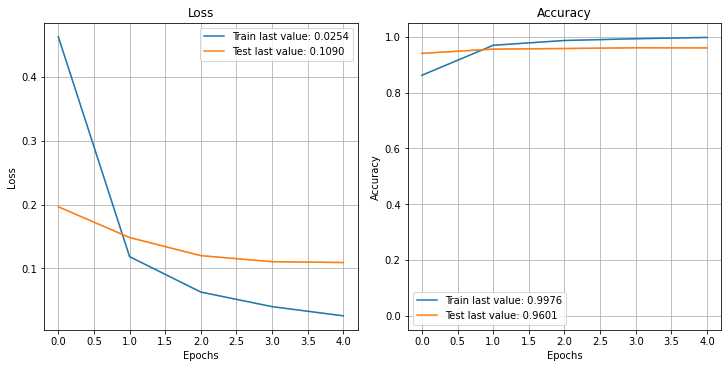

In [16]:
# train the model

hist = model.fit(X_train, y_train_onehot,
                    #class_weight = class_weights_d,
                    epochs=5,
                    verbose=True,
                    validation_data=(X_test, y_test_onehot),
                    batch_size=64).history

loss, accuracy = model.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist)

# Shallow CNN (with Dropout)

In [17]:
model_dp = Sequential()

model_dp.add(Embedding(input_dim = vocab_size, 
                    output_dim = embedding_dim, 
                    input_length = maxlen,
                    weights = [embedding_matrix],
                    trainable = False))

model_dp.add(Conv1D(512, 3, activation='relu'))

model_dp.add(Dropout(0.5))

model_dp.add(GlobalMaxPooling1D())

model_dp.add(Dense(64, activation='relu'))

model_dp.add(Dropout(0.5))

model_dp.add(Dense(8, activation='softmax'))

model_dp.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_dp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 964, 100)          1999800   
                                                                 
 conv1d_1 (Conv1D)           (None, 962, 512)          154112    
                                                                 
 dropout (Dropout)           (None, 962, 512)          0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 512)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                      

Epoch 1/5
84/84 [==============================] - 7s 81ms/step - loss: 0.8544 - accuracy: 0.7371 - val_loss: 0.5430 - val_accuracy: 0.8641
Epoch 2/5
84/84 [==============================] - 6s 73ms/step - loss: 0.4188 - accuracy: 0.8581 - val_loss: 0.3449 - val_accuracy: 0.9110
Epoch 3/5
84/84 [==============================] - 6s 73ms/step - loss: 0.3094 - accuracy: 0.8961 - val_loss: 0.2630 - val_accuracy: 0.9284
Epoch 4/5
84/84 [==============================] - 6s 73ms/step - loss: 0.2596 - accuracy: 0.9110 - val_loss: 0.2590 - val_accuracy: 0.9427
Epoch 5/5
168/168 [==============================] - 2s 14ms/step - loss: 0.1464 - accuracy: 0.9736
Training Accuracy: 0.9736
Testing Accuracy:  0.9501


(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f282237dd50>,
       dtype=object))

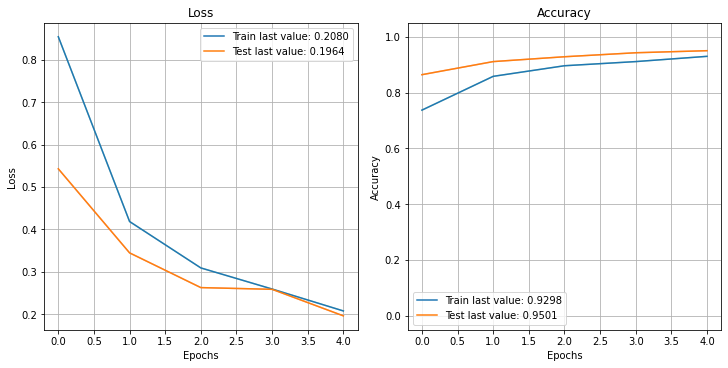

In [18]:
#train the model

hist_dp = model_dp.fit(X_train, y_train_onehot,
                    #class_weight = class_weights_d,
                    epochs=5,
                    verbose=True,
                    validation_data=(X_test, y_test_onehot),
                    batch_size=64).history

loss, accuracy = model_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_dp)

# Deep CNN (Multi-kernels - 2gram, 3gram, 5gram)

In [19]:
# define the model
from keras.layers.merge import concatenate

def define_model(length, vocab_size,embedding_dim):
	# channel 1
	inputs1 = Input(shape=(length,))
	embedding1 = Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False)(inputs1)
	conv1 = Conv1D(filters=128, kernel_size=2, activation='relu')(embedding1)
	drop1 = Dropout(0.5)(conv1)
	pool1 = MaxPooling1D(pool_size=2)(drop1)
	flat1 = Flatten()(pool1)
 
	# channel 2
	inputs2 = Input(shape=(length,))
	embedding2 = Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False)(inputs2)
	conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding2)
	drop2 = Dropout(0.5)(conv2)
	pool2 = MaxPooling1D(pool_size=2)(drop2)
	flat2 = Flatten()(pool2)
 
	# channel 3
	inputs3 = Input(shape=(length,))
	embedding3 = Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False)(inputs3)
	conv3 = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding3)
	drop3 = Dropout(0.5)(conv3)
	pool3 = MaxPooling1D(pool_size=2)(drop3)
	flat3 = Flatten()(pool3)
 
	# merge
	merged = concatenate([flat1, flat2, flat3])
 
	# interpretation
	dense1 = Dense(64, activation='relu')(merged)
	outputs = Dense(8, activation='softmax')(dense1)
	model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
 
	# compile
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 
	# summarize
	print(model.summary())
	return model

model_deep = define_model(maxlen,vocab_size,embedding_dim)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 964)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 964)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 964)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 964, 100)     1999800     ['input_1[0][0]']                
                                                                                              

Epoch 1/5
84/84 [==============================] - 8s 79ms/step - loss: 0.9314 - accuracy: 0.7356 - val_loss: 0.4359 - val_accuracy: 0.8537
Epoch 2/5
84/84 [==============================] - 6s 74ms/step - loss: 0.2665 - accuracy: 0.9166 - val_loss: 0.2620 - val_accuracy: 0.9244
Epoch 3/5
84/84 [==============================] - 6s 74ms/step - loss: 0.0804 - accuracy: 0.9780 - val_loss: 0.2132 - val_accuracy: 0.9366
Epoch 4/5
84/84 [==============================] - 6s 74ms/step - loss: 0.0303 - accuracy: 0.9933 - val_loss: 0.1835 - val_accuracy: 0.9431
Epoch 5/5
168/168 [==============================] - 3s 16ms/step - loss: 0.0113 - accuracy: 0.9981
Training Accuracy: 0.9981
Testing Accuracy:  0.9401


(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f27a2fe5750>,
       dtype=object))

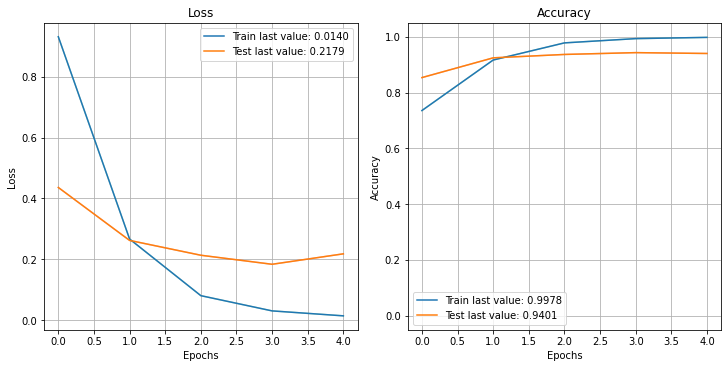

In [20]:
# train the model

hist_deep = model_deep.fit([X_train,X_train,X_train], y_train_onehot,
                    #class_weight = class_weights_d,
                    epochs=5,
                    verbose=True,
                    validation_data=([X_test,X_test,X_test], y_test_onehot),
                    batch_size=64).history

loss, accuracy = model_deep.evaluate([X_train,X_train,X_train], y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_deep.evaluate([X_test,X_test,X_test], y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_deep)

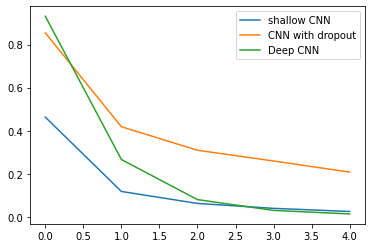

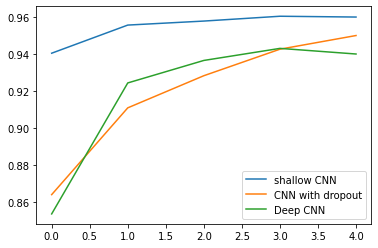

In [21]:
# Compare all the models

plt.plot(hist['loss'], label='shallow CNN')
plt.plot(hist_dp['loss'], label='CNN with dropout')
plt.plot(hist_deep['loss'], label='Deep CNN')
plt.legend(loc='upper right')
plt.show()

plt.plot(hist['val_accuracy'], label='shallow CNN')
plt.plot(hist_dp['val_accuracy'], label='CNN with dropout')
plt.plot(hist_deep['val_accuracy'], label='Deep CNN')
plt.legend(loc='lower right')
plt.show()
